# Sentiment Analysis with Bi-LSTM

## Setup

In [1]:
# Check GPU
!nvidia-smi

Fri May 20 14:02:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

The IMDB large movie review dataset is a *binary classification* dataset — all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
# Load data 
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEWQJZU/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEWQJZU/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEWQJZU/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Dataset = Text (string) + Label (int)
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

[The print of string constant is always attached with 'b' inTensorFlow?](https://stackoverflow.com/questions/40904979/the-print-of-string-constant-is-always-attached-with-b-intensorflow)


Initially this returns a dataset of (text, label pairs):

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# Each batch pair (text, label) mix by 64 pairs
for example, label in train_dataset.take(1):
  print('Texts: ', example.numpy()[:3])
  print('Labels: ', label.numpy()[:3])

Texts:  [b'A pale shadow of a great musical, this movie suffers from the fact that the director, Richard Attenborough, completely misses the point of the musical, needlessly "opens" it up, and muddies the thrust of the play. The show is about a group of dancers auditioning for a job in a B\'way musical and examines their drive & desire to work in this demanding and not-always-rewarding line of work. Attenborough gives us a fresh-faced cast of hopefuls, assuming that they are trying to get their "big break" in show business, rather than presenting the grittier mix of characters created on stage as a group of working "gypsies" living show to show, along with a couple of newcomers. The film has one advantage over the play and that is the opening scene, showing the size of the original audition and the true scale of shrinkage down to the 16/17 on the line (depending on how you count Cassie, who is stupidly kept out of the line in the movie). Anyone who can catch a local civic light opera p

## Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [8]:
# Size of vocab (dim each word before pass Embedding Layer)
VOCAB_SIZE = 10000
# Max length of sentences 
max_length = 256
# Embedding Layer Dim: Aim covert large dim to small dim
embedding_dim = 100

In [9]:
encoder = tf.keras.layers.TextVectorization(VOCAB_SIZE)

# Adapt TextVectorization for train text to build vocab
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 10 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:10]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it'],
      dtype='<U17')

Once the vocabulary is set, the layer can encode text into indices. The tensors of **indices are 0-padded to the longest sequence in the batch** (unless you set a fixed `output_sequence_length`):

In [11]:
# Width of list = size of longest sequence choose from batch
encoded_example = encoder(example)[:3].numpy()
encoded_example.shape

(3, 909)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
print("Original: ", example[1].numpy())
print("Round-trip: ", " ".join(vocab[encoded_example[1]]))

Original:  b'In the year 2006, "In Cold Blood"-a riveting thriller from 1967-has two new interesting contexts that it did not previous have. First, and most chillingly, is the fact that it\'s star, Robert Blake, was recently on trial for murdering his wife. Second, the recent Oscar winning biopic, "Capote" showed the muddled back story of this haunting true crime tale\'s author, Truman Capote. These two new twists make the film timely for a modern audience.<br /><br />As a stand alone film from it\'s era, "In Cold Blood" is top notch in every way. Most notable is the stunning black and white cinematography from Conrad Hall (later of "American Beauty" and "Road to Perdition" fame). Many of the stills from this film of the Kansas farm house at night or the tree-lined back country roads could be sold as fine art photography. Combined with the cracker-jack direction from Brooks and superb editing in the early scenes (where we see the mundane daily life of the innocent family about to be se

## Word2Vec

In [ ]:
# Download weight pre-train Word2Vec
# hub_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-250/2")

## GloVec 

In [13]:
# Download Pretrain GloVec
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-05-20 14:03:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-20 14:03:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-20 14:03:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

[split with max split = 1](https://www.w3schools.com/python/ref_string_split.asp)

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [14]:
# Load file with path 
embeddings_index = {}
with open("/content/glove.6B.100d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [15]:
# Check embedding of words 
embeddings_index["scored"]

array([ 0.20988  , -0.47655  ,  0.28336  , -0.81891  ,  0.69712  ,
        0.60576  ,  0.70267  , -0.37126  , -1.2579   , -0.15087  ,
        0.8627   , -1.0148   , -1.1333   , -0.35162  ,  0.59548  ,
        0.18641  , -0.42956  ,  0.87956  , -0.79354  , -0.11465  ,
        0.93346  ,  0.25379  ,  0.37372  ,  0.58551  ,  0.64899  ,
       -0.41579  , -0.68475  ,  0.33655  ,  0.0084698, -0.52282  ,
       -0.88602  ,  1.1002   ,  0.21214  ,  0.6451   ,  0.72751  ,
       -0.92499  , -0.16333  ,  1.3088   , -1.5823   ,  0.51023  ,
        0.25315  , -0.33866  ,  0.33079  ,  0.0080323,  0.34725  ,
        0.13952  ,  0.38958  , -0.98305  ,  0.46568  , -0.089045 ,
       -0.37794  , -0.049653 , -1.1755   ,  0.73942  , -0.36438  ,
       -2.4471   , -0.75071  ,  0.0901   , -0.32032  ,  1.4176   ,
       -0.69838  ,  0.069092 , -0.779    ,  0.55792  , -0.374    ,
        0.097131 ,  0.098289 ,  0.50688  , -0.8024   ,  0.45312  ,
       -0.43216  ,  0.19852  ,  0.66294  , -0.16279  ,  0.7524

Now, let's prepare a corresponding embedding matrix that we can use in a Keras `Embedding` layer. It's a simple NumPy matrix where entry at index `i` is the pre-trained vector for the word of index `i` in our `vectorizer`'s vocabulary.

In [16]:
voc = encoder.get_vocabulary()
# Assign index with word to dict 
word_index = dict(zip(voc, range(VOCAB_SIZE)))

In [17]:
hits = 0        # Word can converted
misses = 0      # Word can't converted (OOV)

# Prepare embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[index] = embedding_vector
        hits += 1
    else:
        misses += 1

# Check acc
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9691 words (309 misses)


Next, we load the pre-trained word embeddings matrix into an `Embedding` layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training).

In [18]:
# Check train dataset
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
model_glovec = tf.keras.Sequential([
    # Must have add "encoder" layers to convert data train to string
    encoder,
    # Embedding
    tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_dim,
                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False),
    # Bidirectional LSTM 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)])

model_glovec.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              60400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [20]:
# Compile & Fit model 
model_glovec.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics='acc')

history = model_glovec.fit(train_dataset, epochs= 10,
                    validation_data = test_dataset,
                    validation_steps = 30)

Epoch 1/10
391/391 [==============================] - 36s 70ms/step - loss: 0.6854 - acc: 0.5031 - val_loss: 0.6569 - val_acc: 0.5161
Epoch 2/10
391/391 [==============================] - 27s 69ms/step - loss: 0.6283 - acc: 0.6317 - val_loss: 0.5802 - val_acc: 0.7156
Epoch 3/10
391/391 [==============================] - 27s 67ms/step - loss: 0.5720 - acc: 0.7118 - val_loss: 0.5478 - val_acc: 0.7443
Epoch 4/10
391/391 [==============================] - 27s 68ms/step - loss: 0.5445 - acc: 0.7365 - val_loss: 0.5248 - val_acc: 0.7568
Epoch 5/10
391/391 [==============================] - 27s 68ms/step - loss: 0.5315 - acc: 0.7455 - val_loss: 0.5186 - val_acc: 0.7302
Epoch 6/10
391/391 [==============================] - 27s 68ms/step - loss: 0.5074 - acc: 0.7585 - val_loss: 0.4983 - val_acc: 0.7776
Epoch 7/10
391/391 [==============================] - 27s 69ms/step - loss: 0.4874 - acc: 0.7736 - val_loss: 0.4741 - val_acc: 0.7911
Epoch 8/10
391/391 [==============================] - 27s 69ms

In [21]:
# Evaluation 
model_glovec.evaluate(test_dataset)

391/391 [==============================] - 15s 38ms/step - loss: 0.4822 - acc: 0.7932


[0.4821780323982239, 0.7932000160217285]

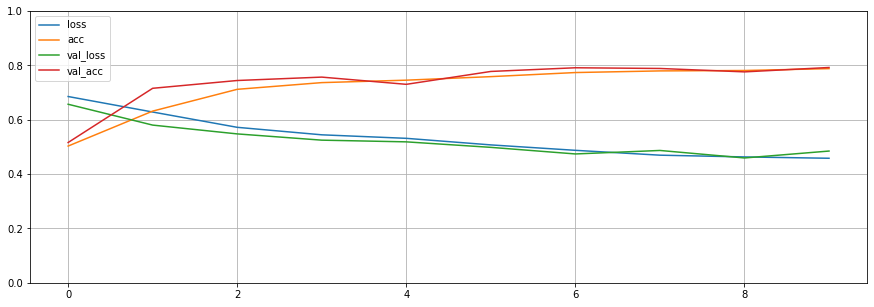

In [22]:
# Visualization, fit() method has history.history (dict of loss & metric end of each epoch)
pd.DataFrame(history.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1);

## Bi-LSTM

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [23]:
model_bilstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim = 100,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # Bidirectional LSTM 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25)),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)])

model_bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 100)        60400     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 50)               25200     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                      

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
# Check masking layers
[layer.supports_masking for layer in model.layers]

To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# Predict on a sample text without padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Prediction
model.predict(np.array([sample_text]))

Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# Predict on a sample text with padding
padding = "the " * 2000
model.predict(np.array([sample_text, padding]))

Compile the Keras model to configure the training process:

In [24]:
# Compile the model 
model_bilstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics='acc')

# Train the model 
history = model_bilstm.fit(train_dataset, epochs= 10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 70s 142ms/step - loss: 0.6155 - acc: 0.5976 - val_loss: 0.4188 - val_acc: 0.8401
Epoch 2/10
391/391 [==============================] - 52s 132ms/step - loss: 0.3268 - acc: 0.8750 - val_loss: 0.3081 - val_acc: 0.8703
Epoch 3/10
391/391 [==============================] - 52s 133ms/step - loss: 0.2358 - acc: 0.9154 - val_loss: 0.2937 - val_acc: 0.8755
Epoch 4/10
391/391 [==============================] - 52s 132ms/step - loss: 0.1888 - acc: 0.9369 - val_loss: 0.3068 - val_acc: 0.8760
Epoch 5/10
391/391 [==============================] - 53s 133ms/step - loss: 0.1543 - acc: 0.9522 - val_loss: 0.3570 - val_acc: 0.8771
Epoch 6/10
391/391 [==============================] - 52s 133ms/step - loss: 0.1229 - acc: 0.9638 - val_loss: 0.3829 - val_acc: 0.8755
Epoch 7/10
391/391 [==============================] - 53s 134ms/step - loss: 0.1031 - acc: 0.9716 - val_loss: 0.4417 - val_acc: 0.8615
Epoch 8/10
391/391 [==============================] - 5

In [25]:
# Evaluation
test_loss, test_acc = model_bilstm.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 28s 72ms/step - loss: 0.5305 - acc: 0.8670
Test Loss: 0.5305224061012268
Test Accuracy: 0.8669999837875366


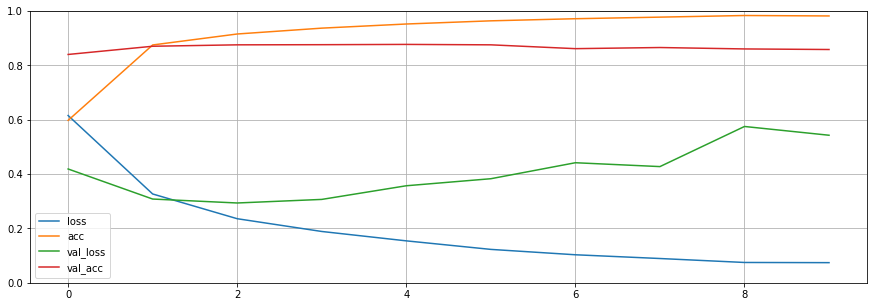

In [26]:
# Visualization
pd.DataFrame(history.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1);

Run a prediction on a new sentence

If the prediction is >= 0.0, it is positive else it is negative.

In [29]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

model_bilstm.predict(np.array([sample_text]))

array([[1.7799897]], dtype=float32)